# Watershed Algorithm
## Definition
In geography a watershed is a land area that channels rainfall and snowmelt to creeks, streams and rivers and eventually to outflow points such as reservoirs, bays and the ocean.

These watersheds can then be segmented as topographical maps with boundaries.

Metaphorically, the watershed algo transformation treats the image it operates upon like a topographic map, with the brightness of each point representing its height and finds the lines that run along the tops of ridges.

Any grayscale image can be viewed as a topographic surface where <b>high intensity</b> denotes peaks and hills while <b>low intensity</b> denotes valleys

The algorithm can then fill every isolated valleys (local minima) with different colored water (labels).

As the "water" (intensity) rises, depending on the peaks (gradients) nearby, "water" from different valleys (different segments of the image), with different colors could start to merge.

To avoid this merging, the algorithm creates barriers (segment edge boundaries) in locations where "water" merges.

## When is this algorithm useful
This algorithm performs well for segmenting the background and foreground of an image.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import skimage as ski

In [2]:
def display_img(img, cmap="gray"):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap)

In [5]:
sep_coins = cv2.imread("images/coins.jpeg")

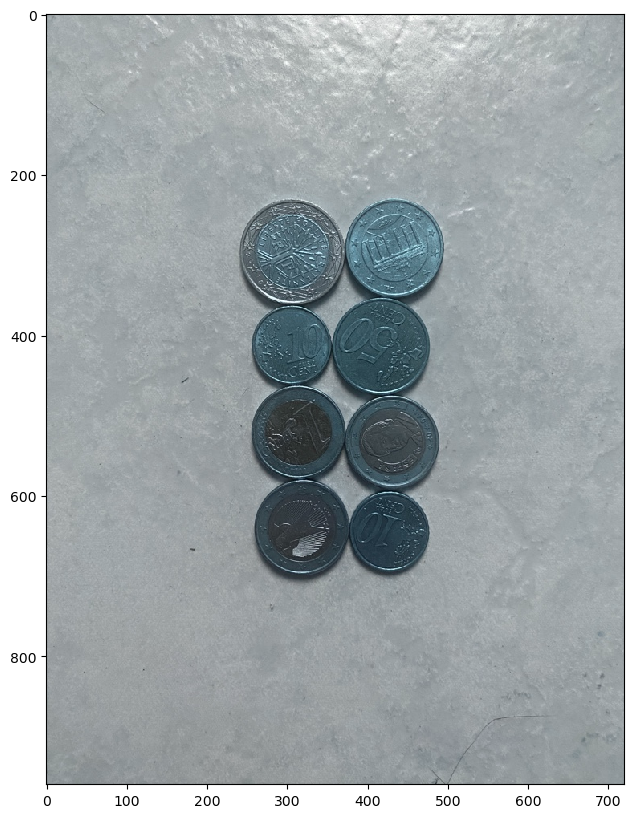

In [6]:
display_img(sep_coins)

In [7]:
# Task, segment the image into 8 different regions and background

## classic (already known) algorithms
We first apply the already known algorithms to have a baseline to compare with.

### Steps
1. Apply median blur -> get rid of things that we don't really need (like coin faces etc)
2. grayscale
3. apply a binary threshold
4. find the contours

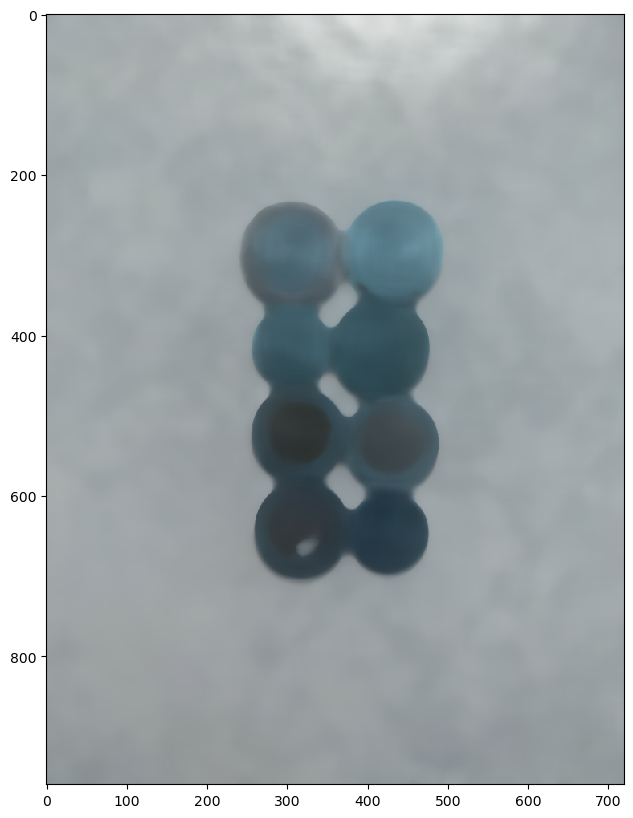

In [8]:
sep_blur = cv2.medianBlur(sep_coins, 25)
display_img(sep_blur)

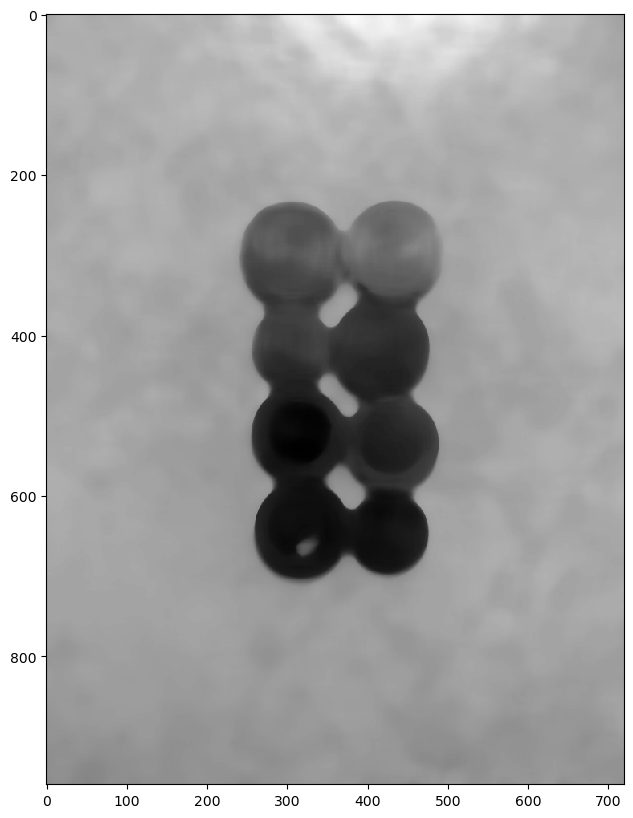

In [11]:
gray_sep_coins = cv2.cvtColor(sep_blur, cv2.COLOR_BGR2GRAY)
display_img(gray_sep_coins)

In [24]:
ret, sep_thresh = cv2.threshold(gray_sep_coins, 145, 255, cv2.THRESH_BINARY_INV)

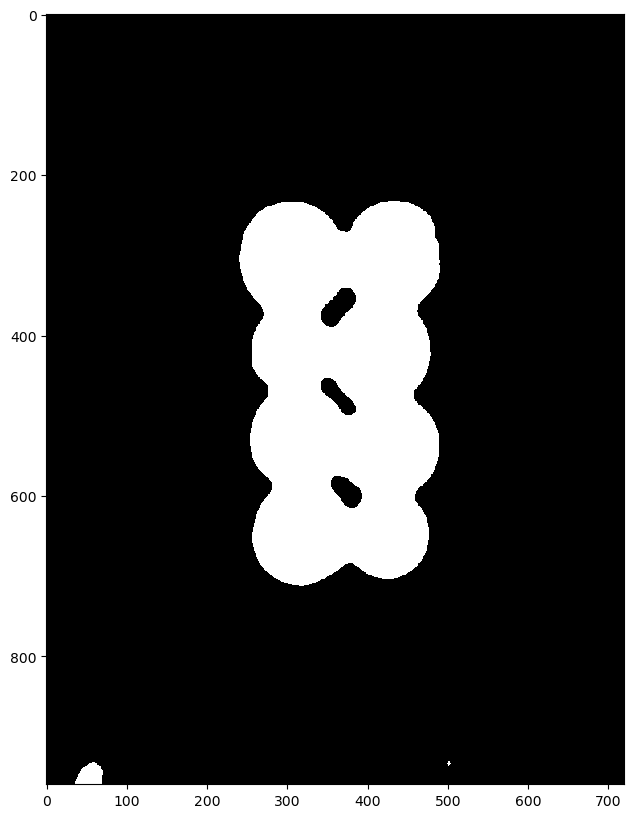

In [25]:
display_img(sep_thresh)

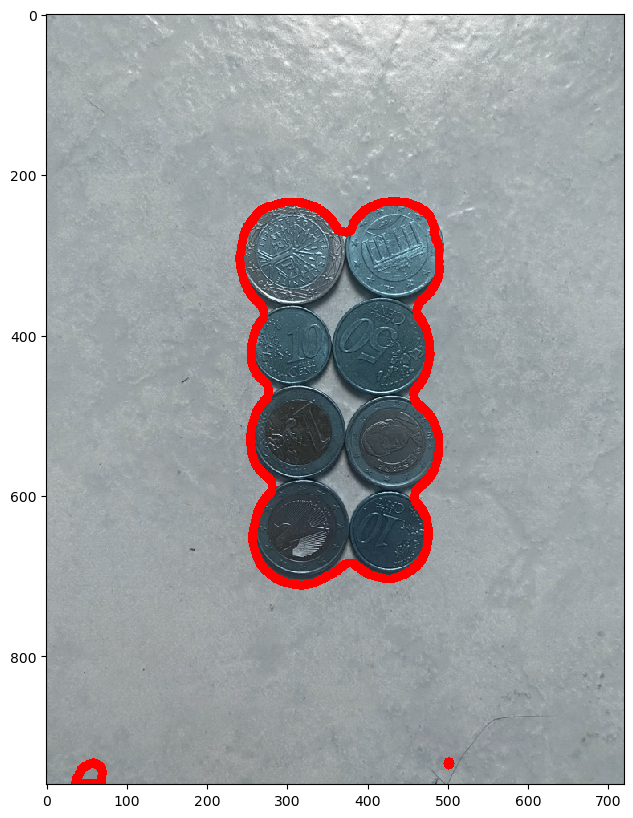

In [28]:
contours, hierarchy = cv2.findContours(sep_thresh.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
for i in range(len(contours)):
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(sep_coins, contours, i, (255,0,0), 10)

display_img(sep_coins)
# Observation: The contours the algorithm found is only one large contour around all coins. The reason is, that the objects
#  are not separated from each other. Since there is no gap between the coins the algorithm treated it as one large object.
#  One could try to distore the image further by erotion to make the gaps larger, but that would destroy the original image and 
#  would move the boundaries of the coins to a wrong position.
#  -> Let's see how the watershed algorithm performs.

## Watershed algorithm

### Steps
1. Read in the image
2. apply a blur (strong blur for larger images)
3. convert to grayscale
4. Apply threshold to the image + (Otsus method (threshold method))
5. Noise removal (optional, but needed especially for busy / complicated images)
6. Set seeds for

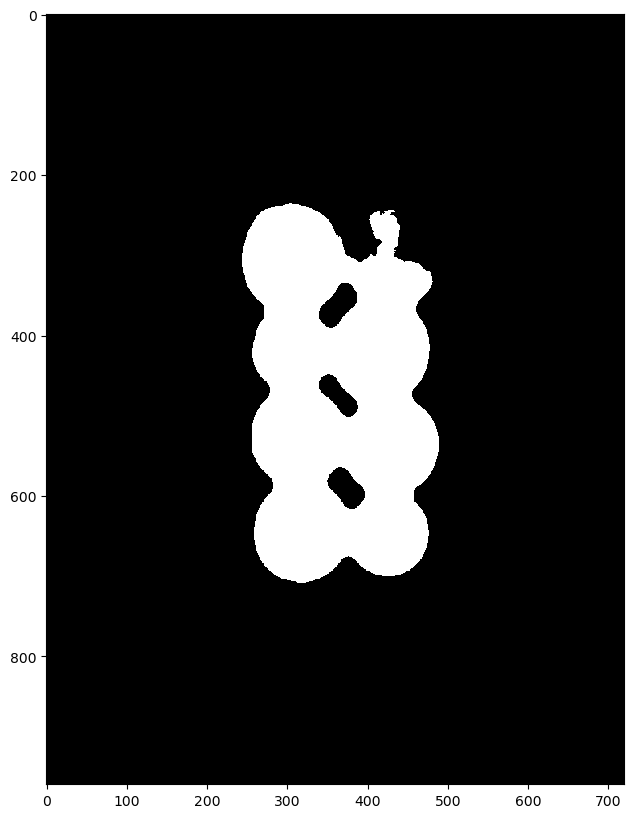

In [41]:
img = cv2.imread("images/coins.jpeg")
img = cv2.medianBlur(img, 45)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, sep_thresh = cv2.threshold(gray_sep_coins, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
display_img(sep_thresh)

In [42]:
# noise removal
kernel = np.ones((3,3), np.uint8)
kernel

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]], dtype=uint8)

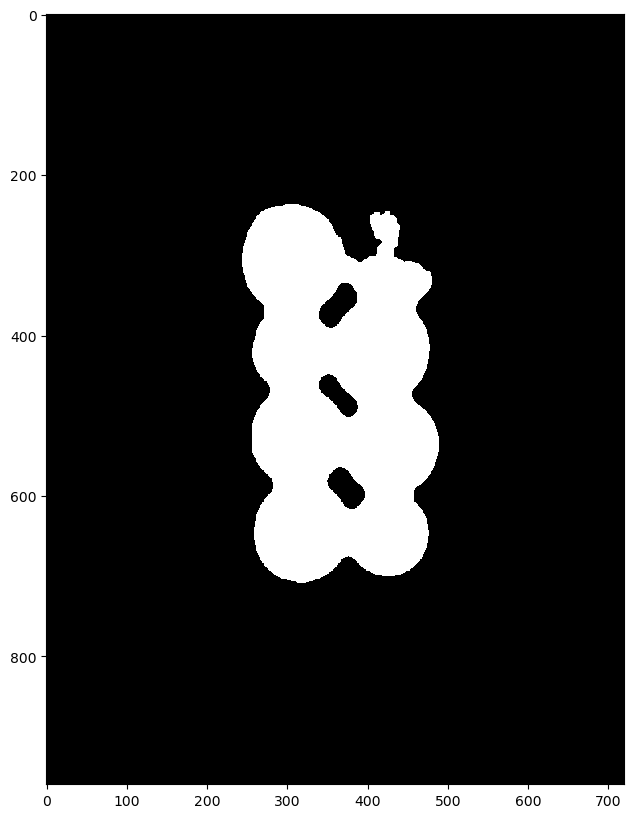

In [43]:
opening = cv2.morphologyEx(sep_thresh, cv2.MORPH_OPEN, kernel, iterations=2)
display_img(opening)
# sure background area
sure_background = cv2.dilate(opening,kernel,iterations=3)

In [44]:
# Still the fundamental problem persists: The coins are still touching each other in the image. That caused the issue for the
#  "classic" segmentation.

# Distance Transform to place a seed:
# For example a distance transform of a binary image would mark each pixel and it's distance to the nearest 0 with an integer.
# See: https://en.wikipedia.org/wiki/Distance_transform 
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

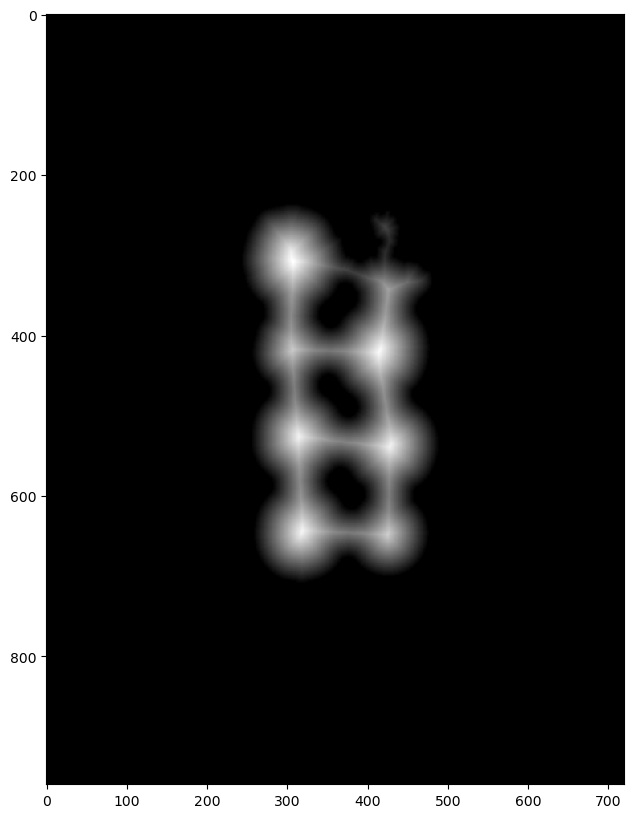

In [45]:
display_img(dist_transform)
# Observation: Very bright on the inside of the coins and it gets darker as the pixels move to the outside of the coin

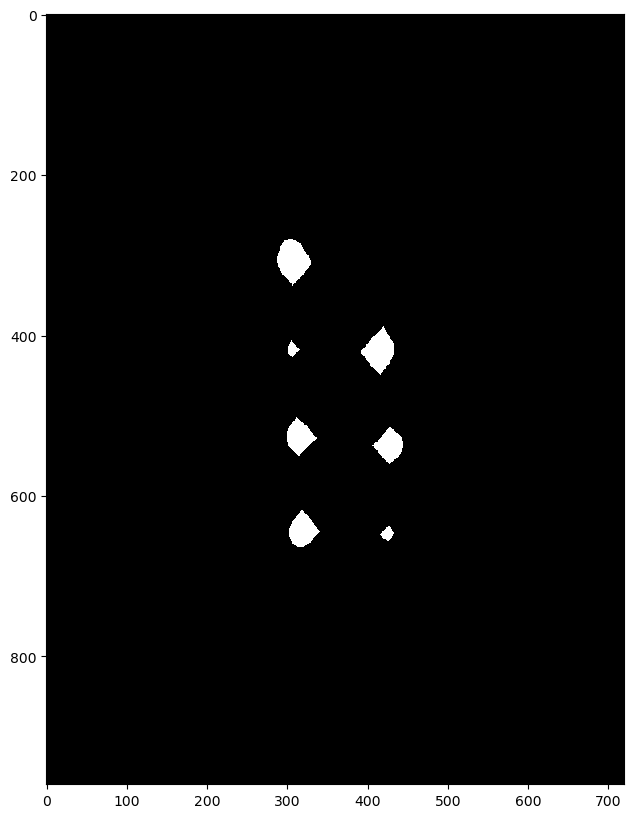

In [46]:
ret, sure_foreground = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
display_img(sure_foreground)

In [ ]:
sure_foreground = np.uint8(sure_foreground)
unknown_region = cv2.subtract(sure_bg)